<a href="https://colab.research.google.com/github/Nyandala/Climate-Change-Belief-Analysis-Supervised-ML/blob/main/Final_Notebook__Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

### [1. Introduction](#introduction)
1.1. Project overview

1.2. Problem statement


### [2. Start Comet experiment](#scomet)
### [3. Package and module imports](#pack)
### [4. Load data](#load)
### [5. Description of the data](#dod)
### [6. Data pre-processing](#cleaning)
6.1. Null values and duplicates

6.2. Empty strings

6.3. Special characters

6.4. Stop words

6.5. Full context of tweets before and after data pre-processing

### [7. Exploratory Data Analysis](#eda)
7.1. Sentiment distribution

7.2. Length of tweets

7.3. Hashtags extraction

7.4. Wordcloud visualisation

7.5 URL extraction
### [8. Feature engineering](#pp)

8.1. Select feature and label variables

8.2. Dealing with class imbalance

8.3. Tokenization and lemmatization

8.4. Vectorization

### [9. Modelling](#mod)
### [10. Model evaluation](#me)
### [11. Conclusion](#conc)
### [12. End Comet experiment](#ecomet)

<a id="introduction"></a>
# 1. Introduction

## 1.1. Project overview

Sentiment analysis is the process of interpreting and classifying the feelings behind a message based on the usage of a series of words through the employment of text analysis techniques. Sentiment anaysis is helpful in determining the general public opinion towards a certain topic. Subsequently, businesses can utilise this information when designing their products and services and also  moulding their marketing strategies. It can form a part of customer feedback. Additionally, these text analysis techniques can be used to extract insights from bodies of text as well.

With the change in time, consumers have become more conscience about acquiring products/services from brands that uphold certain values and ideals.They also consider the service provider's stances towards issues such as climate change. In order to appeal to these consumers, organisations should understand their sentiments.They need to understand how their products will be received whilst trying to decrease their environmental impact or carbon footprint. This can be achieved using Machine Learning.

Machine learning is a subset of Artifical Intelligence in which algorithms are applied to teach computers to make decisions, with little to no human intereference. Classification is a branch of Machine Learning where models are trained to pick up patterns in preexisting data then subsequently classify unseen data into appropriate classes. Classifiers will be used to categorise the tweets into four sentiment classes.



## 1.2. Problem statement

Build a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data. 

<a id="scomet"></a>
# 2. Start Comet Experiment

Comet is a cloud-based platform that allows teams to preserve and compare the different models that have been built during a project. It is an effective tool for version control. We have saved all of our models as Comet experiments.

In [ ]:
# Install Comet and import Experiment class
!pip install comet_ml
from comet_ml import Experiment

In [ ]:
# Start experiment
experiment = Experiment(api_key="XXXXXXXX",
                        project_name="XXXXXXXX",
                        workspace="XXXXXX")

In [ ]:
# Set experiment name, new name for each run
experiment.set_name('XXXXXX')

<a id="pack"></a>
# 3. Package and module imports

In [1]:
# Data wrangling
import numpy as np 
import pandas as pd 

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Text processing
import string
import re
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Data processing
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split

# Model imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 

# Metrics
from sklearn.metrics import accuracy_score, log_loss, precision_score 
from sklearn.metrics import recall_score, precision_recall_curve, f1_score, classification_report, confusion_matrix
from collections import defaultdict


# Kaggle input
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Silence warnings for clean flow of notebook
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<a id="load"></a>
# 4. Load data

In [4]:
url_train = 'https://raw.githubusercontent.com/Nyandala/Climate-Change-Belief-Analysis-Supervised-ML/main/Data/train.csv'
url_test = 'https://raw.githubusercontent.com/Nyandala/Climate-Change-Belief-Analysis-Supervised-ML/main/Data/test.csv'

df = pd.read_csv(url_train)
test = pd.read_csv(url_test)

In [5]:
display(df.head())
display(test.head())

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


<a id="dod"></a>
# 5. Description of the data

Two datasets were provided, namely train.csv and test.csv. These datasets will be used to train and test the model respectively. They contain tweets, related to climate change, which were collected between April 27, 2015 and February 21, 2018.

There are three variables defined in the train.csv dataset:

1. Sentiment - Sentiment of tweet

2. Message - Tweet body

3. Tweetid - Twitter unique id


The sentiment variable is divided into four sentiment classes which the tweets are accordingly grouped into based on their content. The classes are stipulated as follows:

![inbox_2205222_8e4d65f2029797e0462b52022451829c_data.png](attachment:inbox_2205222_8e4d65f2029797e0462b52022451829c_data.png)



<a id="cleaning"></a>
# 6. Data pre-processing

Data pre-processing is the process of identifying errors and modifying or removing parts of the data in order to improve its overall quality. It is important as it enhances the dataset's reliability therefore providing more accurate information,allowing for optimal insights extraction and also receiving improved model results.

Upon basic inspection of the top 5 records of our datasets, the initial data cleaning requirements are as follows:

* Remove duplicates, blank strings & null values

* Remove twitter handles

* Remove punctuation and other redundant special characters

* Filter out stop words

## 6.1. Null values and duplicates

Missing values, mainly known as null values, occur due to multiple reasons including errors whilst collecting data. These values are removed because they add no value to the output of the models; all data has to be valid and valued. Duplicates are also removed as they do not provide any new information. The reduced number of values also result in less model run time.

In [6]:
# Detect and remove NaN values as well as duplicate rows
df = df.drop_duplicates(subset=['message'])
display(df.isnull().sum())
display(test.isnull().sum())

sentiment    0
message      0
tweetid      0
dtype: int64

message    0
tweetid    0
dtype: int64

## 6.2. Empty Strings

Empty strings are removed because they add no value to the dataset.

In [7]:
def remove_blanks(df):
    """
    Takes in a dataframe, detects empty strings and removes them.

    Parameters:
    ---------
    DataFrame 

    Returns:
    ---------
    DataFrame:Dataframe with no empty strings

    """
    blanks = []
    for index, tweet in enumerate(df['message']):
        if type(tweet) == str:
            if tweet in ['', ' ']:
                blanks.append(index)
    print(blanks)
    return df.drop(blanks)

In [8]:
# Remove blanks in train and test datasets
df = remove_blanks(df)
test = remove_blanks(test)

[]
[]


## 6.3. Special Characters

Punctuation and other special characters are removed from the text in order to transform the data into a more useable format.

In [9]:
def clean_text(text):
    """
    Takes in text, cleans it by making it lowercase,
    removes links/urls, punctuations etc. and returns it a clean text.

    Parameters:
    ---------
    text (str):String text

    Returns:
    ---------
    str:Clean text

    """
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', 'URL', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [10]:
# Cleaning text in train and test datasets
df['clean_tweet'] = df['message'].apply(lambda x: clean_text(x))
test['clean_tweet'] = test['message'].apply(lambda x: clean_text(x))

## 6.4. Stop Words

Stop words are words commonly used in English such as "I", "is", "the" etc. These do not carry a vast amount of useful information thus they are filtered out. Classification accuracy can also be increased as removing stop words results in fewer and more meaningful tokens. The NLTK library has an English list of stop words which can be downloaded and utilised for this process.

In [11]:
stop_words = stopwords.words('english')  # Assign stop_words list


def remove_stopword(text):
    """
    Takes in text and removes stop words.

    Parameters:
    ---------
    text (str):String text

    Returns:
    ---------
    str:Text without stop words

    """
    return [word for word in text.split() if word not in stop_words]

In [12]:
# Removing stop words in train and test datasets
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: remove_stopword(x))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: remove_stopword(x))

In [13]:
def join_tweet(text):
    return ' '.join(text)

In [14]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: join_tweet(x))
df.head()

,sentiment,message,tweetid,clean_tweet
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say three years act cl...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas racist sexist climate chang...


## 6.5. Full context of tweets before and after data pre-processing

The raw data and the preprocessed data can be compared.

In [15]:
# Original tweets
for index, text in enumerate(df['message'][0:5]):
    print('Tweet %d:\n' % (index+1), text)

Tweet 1:
 PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable
Tweet 2:
 It's not like we lack evidence of anthropogenic global warming
Tweet 3:
 RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
Tweet 4:
 #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD
Tweet 5:
 RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight


In [16]:
# Clean tweets
for index, text in enumerate(df['clean_tweet'][0:6]):
    print('Tweet %d:\n' % (index+1), text)

Tweet 1:
 polyscimajor epa chief doesnt think carbon dioxide main cause global warming wait URL via mashable
Tweet 2:
 like lack evidence anthropogenic global warming
Tweet 3:
 rt rawstory researchers say three years act climate change it’s late URL URL
Tweet 4:
 todayinmaker wired pivotal year war climate change URL
Tweet 5:
 rt soynoviodetodas racist sexist climate change denying bigot leading polls electionnight
Tweet 6:
 worth read whether dont believe climate change URL URL


In [17]:
df.head()

,sentiment,message,tweetid,clean_tweet
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say three years act cl...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas racist sexist climate chang...


<a id="eda"></a>
# 7. Exploratory Data Analysis And Insights

Exploratory Data Analysis (EDA) is a fundamental part of the Machine Learning process. The data is analysed in order to extract information that a model may overlook. In this section, we will summarise the main characteritics of the data and also look into the sentiment classes provided in our training datasets.



## 7.1. Sentiment distribution

The distribution of the sentiments needs to analysed in order to determine if there is a data imbalance. Datasets are rarely balanced; imbalanced data is a norm in the real world.

In [18]:
# Checking number of values under each sentiment
df['sentiment'].value_counts()

 1    7222
 2    3542
 0    2244
-1    1221
Name: sentiment, dtype: int64

The tweet sentiments from the provided training dataset show an imbalance in the distribution of classes.  It is clearer to see when visualised.

Text(0.5, 1.0, 'Distribution of sentiment group count')

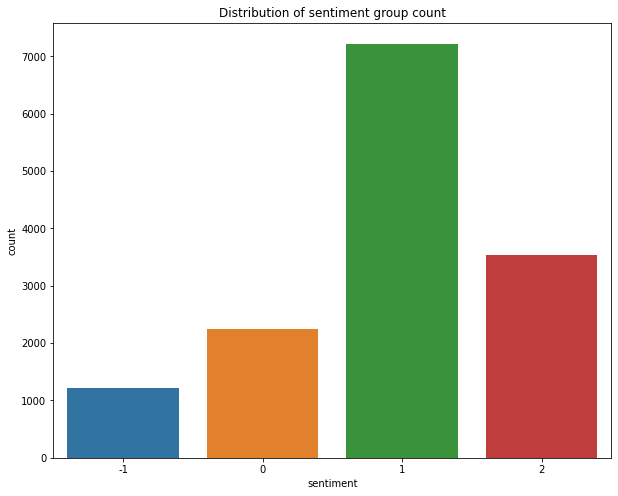

In [19]:
# Plot sentiment distribution
fig, ax = plt.subplots(figsize=(10, 8))
graph = sns.countplot(x='sentiment', data=df, ax=ax)
plt.title('Distribution of sentiment group count')

More than half of the tweets , precisely 50,76%, belong to class 1. This indicates that the majority of tweets collected support the belief that man-made climate change exists. Conversely, 8.58% of the tweets collected are class -1, which represents tweets that do not believe in man-made climate change. Tweets that link to factual news about climate change comprise 24,89% whilst tweets which are neutral (neither supports nor refutes the belief of man-made climate change) make up 15,77% of the dataset. These are represented by the classes 2 and 0 respectively.

The class imbalance will need to be addressed to avoid the model being biased towards classifying sentiments as the majority class because the model will be well-versed in identifying it.

## 7.2. Length of tweets

The length of the tweets, based on the number of words, characters and punctuation, can be characteristic of a sentiment class. These will be analysed and visualised.

In [20]:
# Simple word split to get an idea of the raw tweet length
# Will add new column for count that can be removed after analysis
df['word count'] = df['message'].apply(lambda t: len(t.split()))
df.head()

,sentiment,message,tweetid,clean_tweet,word count
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,19
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,10
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say three years act cl...,19
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,15
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas racist sexist climate chang...,18


In [21]:
# Get a number summary of the word count variable
df.groupby('sentiment')['word count'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
-1,1221.0,18.280917,4.498328,3.0,16.0,19.0,22.0,29.0
0,2244.0,16.473262,5.580497,2.0,12.0,17.0,21.0,31.0
1,7222.0,18.565910,4.108421,3.0,16.0,19.0,21.0,31.0
2,3542.0,15.368436,3.390944,6.0,13.0,15.0,18.0,26.0


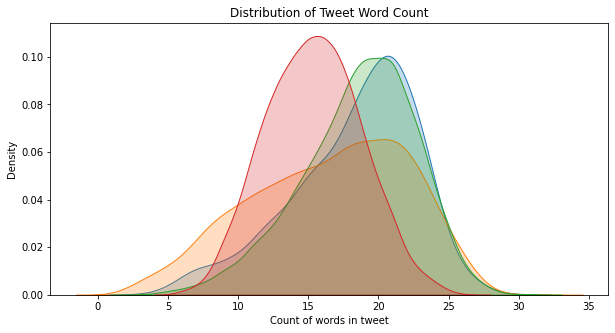

In [22]:
# Plot tweet word count distribution
fig, ax = plt.subplots(figsize=(10, 5))

# create graphs
sns.kdeplot(df['word count'][df['sentiment'] == -1], shade=True, label='Anti')
sns.kdeplot(df['word count'][df['sentiment'] == 0], shade=True,
            label='Neutral')
sns.kdeplot(df['word count'][df['sentiment'] == 1], shade=True, label='Pro')
sns.kdeplot(df['word count'][df['sentiment'] == 2], shade=True, label='News')

# set title and labels
plt.xlabel('Count of words in tweet')
plt.ylabel('Density')
plt.title('Distribution of Tweet Word Count')
plt.show()

Looking at the number of words per tweet, although classes 0 and 1 have the same maximum number of words per tweet at 31 words, classes -1 and 1 have the highest average number of words per tweet at ~19 words. This suggests that people that sent out tweets which are anti and pro man-made climate change send out tweets with more words. News tweets generally have the least number of words with a maximum of 26 and an average of ~16 words per tweet. They do however also display more of a normal distribution, insinuating that news tweets are more consistent in the number of words. The number of words of tweets which are classified as neutral have the greatest distribution with a standard deviation of ~6 words, they vary from "few" to "many" words in a tweet.

The amount of characters per tweet will be analysed to pick up an patterns, if present. Some sentiment classes may send out shorter or longer tweets.

In [23]:
# Create new column to check tweet character length
df['count_characters'] = df['message'].apply(lambda c: len(c))
df.head()

,sentiment,message,tweetid,clean_tweet,word count,count_characters
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,19,140
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,10,62
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say three years act cl...,19,140
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,15,99
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas racist sexist climate chang...,18,122


In [24]:
# Get a number summary of the word count character variable
df.groupby('sentiment')['count_characters'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
-1,1221.0,123.317772,24.151583,34.0,114.0,134.0,140.0,166.0
0,2244.0,110.342246,32.413492,14.0,85.0,123.0,139.0,174.0
1,7222.0,126.799640,20.395932,22.0,119.0,135.0,140.0,208.0
2,3542.0,119.704404,19.093873,48.0,107.0,123.0,137.0,166.0


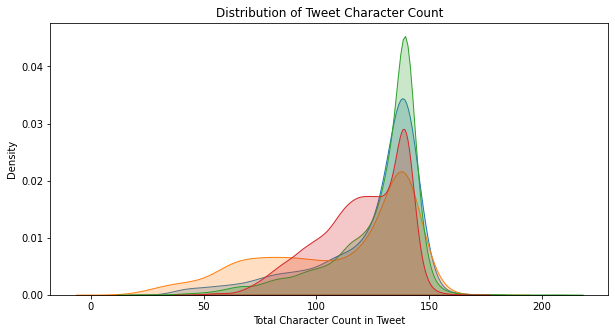

In [25]:
# Plot tweet character count distribution
fig, ax = plt.subplots(figsize=(10, 5))

# Create graphs
sns.kdeplot(df['count_characters'][df['sentiment'] == -1], shade=True,
            label='Anti')
sns.kdeplot(df['count_characters'][df['sentiment'] == 0], shade=True,
            label='Neutral')
sns.kdeplot(df['count_characters'][df['sentiment'] == 1], shade=True,
            label='Pro')
sns.kdeplot(df['count_characters'][df['sentiment'] == 2], shade=True,
            label='News')

# Set title and label
plt.xlabel('Total Character Count in Tweet')
plt.ylabel('Density')
plt.title('Distribution of Tweet Character Count')
plt.show()

A similar pattern as established by the number of words per tweet is displayed by the number of characters per tweet. Classes 1 and 0 have the the first and second maximum number of characters per tweet at at 208 and 166 characters respectively. However, classes 1 and -1 have the highest average number of characters per tweet at ~127 and ~124 characters. A slight difference is that class 2 tweets are on average longer than neutral tweets.

The same analysis for punctuation will be carried out. Some sentiment groups may be likely to use more or less punctuation.

In [26]:
# Repeat for punctuation
df['punctuation_count'] = df['message'].apply(lambda x: len([i for i in str(x)
                                              if i in string.punctuation]))

# Get a number summary of the panctuation count variable
df.groupby('sentiment')['punctuation_count'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
-1,1221.0,7.123669,3.447537,0.0,5.0,7.0,9.0,36.0
0,2244.0,6.161319,3.664582,0.0,3.0,6.0,9.0,25.0
1,7222.0,7.342703,3.402159,0.0,5.0,7.0,10.0,58.0
2,3542.0,8.806606,3.120317,0.0,7.0,8.0,11.0,20.0


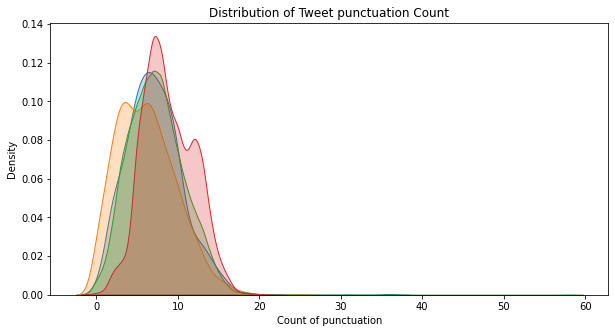

In [27]:
# Plot tweet punctuation count distribution
fig, ax = plt.subplots(figsize=(10, 5))

# Create graphs
sns.kdeplot(df['punctuation_count'][df['sentiment'] == -1], shade=True,
            label='Anti')
sns.kdeplot(df['punctuation_count'][df['sentiment'] == 0], shade=True,
            label='Neutral')
sns.kdeplot(df['punctuation_count'][df['sentiment'] == 1], shade=True,
            label='Pro')
sns.kdeplot(df['punctuation_count'][df['sentiment'] == 2], shade=True,
            label='News')

# Set title and label
plt.xlabel('Count of punctuation')
plt.ylabel('Density')
plt.title('Distribution of Tweet punctuation Count')
plt.show()

The amount of punctuaton displays a number of outliers in each class at 36, 25, 58 and 20 for classes -1, 0, 1 and 2 whilst the averages for each class are ~ 8, 7, 8 and 9. There is a miniscule difference in the means therefore the number of punctuation per tweet can not be as an unique identifier for any of the sentiment classes.

Despite classes -1 and 0 having tweets which have the most characters and words, the differences between these two classes and the other classes, and additonally themselves, are not significant enough to use these two characteristics as features when classifying between the four classes in question. As mentioned above, there are no punctuation patterns that are significant to either class.

## 7.3. Hashtags extraction

Hashtags are insightful as they indicate which subtopics were trending at any given time. Finding out which hashtags trended amongst the sentiment classes can indicate which topics were popular within that particular class and may be significant in identifying them.

In [28]:
def hashtags_extract(text):
    """
    Takes in text, exctracts the hashtags in the text and stores them
    in a list.

    Parameters:
    ---------
    text (str):String text

    Returns:
    ---------
    list of str:Hahtags

    """
    text = str(text).lower()
    hashtags = []
    for token in text.split():
        if token.startswith('#'):
            hashtags.append(token[1:])
    return hashtags

In [29]:
# Extract hashtags from train data and group them by sentiment
df['hashtags'] = df['message'].apply(lambda x: hashtags_extract(x))

df_ht = df.groupby('sentiment')['hashtags'].sum()
df_ht.head()

sentiment
-1    [nomorescams, nomoredemocrats, draintheswamp, ...
 0    [qanda, h…, coag, airquality, climatechange, g...
 1    [todayinmaker#, electionnight, climatemarch, s...
 2    [climate, climatechange, climatechange, p2, cl...
Name: hashtags, dtype: object

In [30]:
# Creating a hashtag list for every sentiment
news_ht = df_ht.loc[1, ]
pro_ht = df_ht.loc[2, ]
neutral_ht = df_ht.loc[0, ]
anti_ht = df_ht.loc[-1]

The top 10 hashtags for each sentiment class will be plotted for better visualisation.

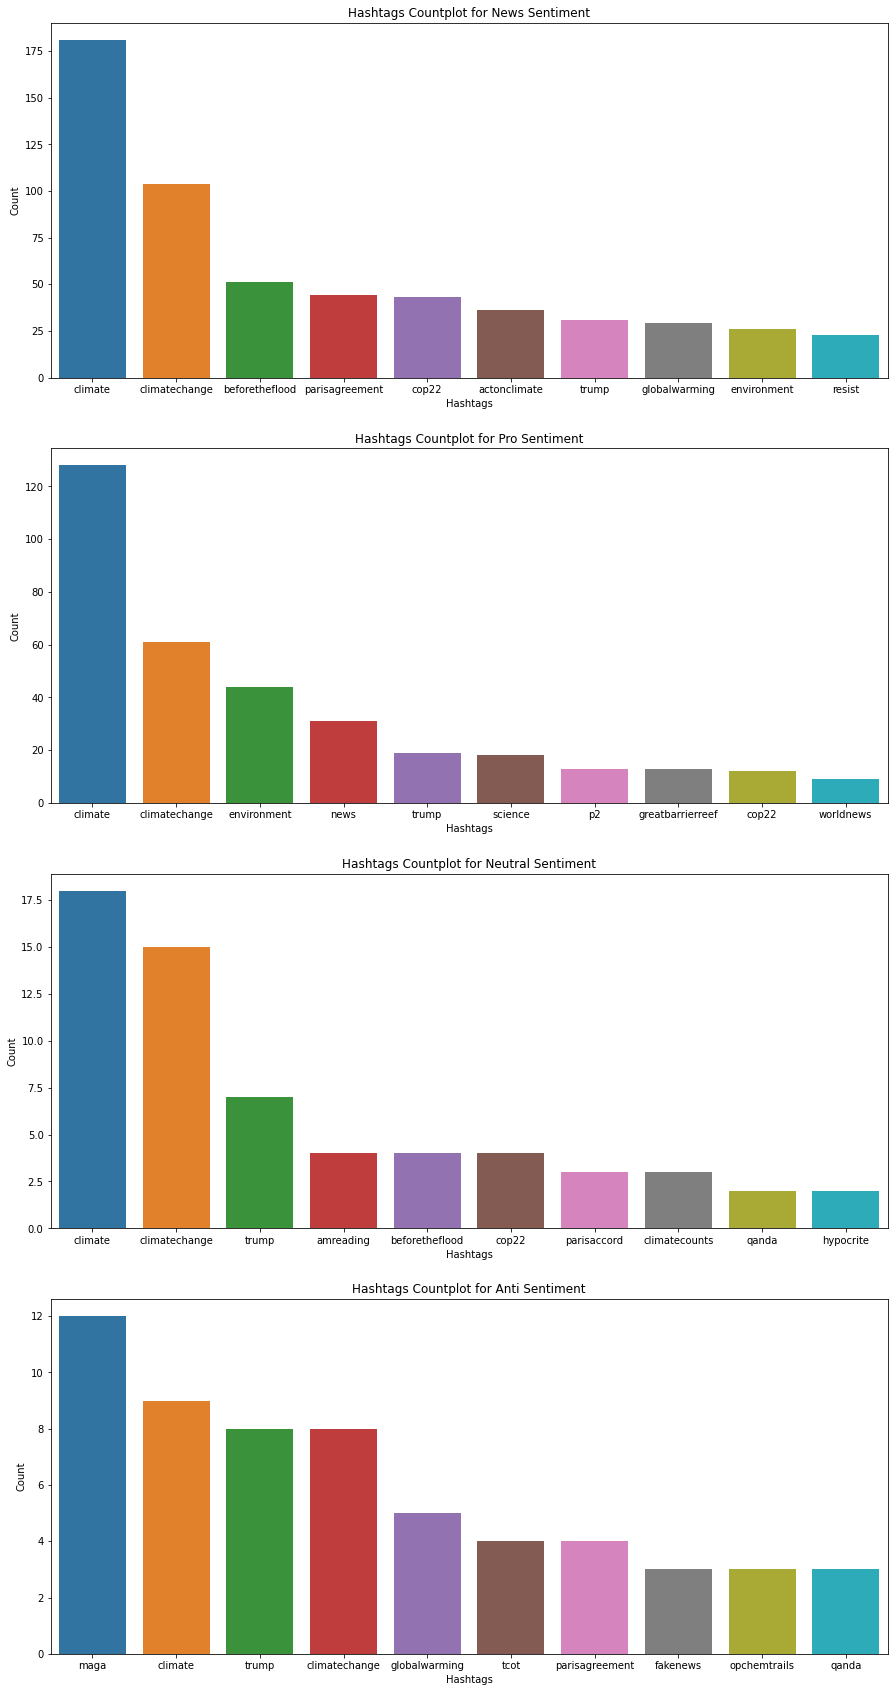

In [31]:
# Plot the top n hashtags for each sentiment
my_feqlist = []
my_dframe = []
for index, ht in enumerate([news_ht, pro_ht, neutral_ht, anti_ht]):
    my_feqlist.append(nltk.FreqDist(ht))
    my_dframe.append(pd.DataFrame({'Hashtag': list(my_feqlist[index].keys()),
                     'Count': list(my_feqlist[index].values())}))
    # selecting top 10 most frequent hashtags
    my_dframe[index] = my_dframe[index].nlargest(columns="Count", n=10)

fig, ax = plt.subplots(4, 1, figsize=(15, 30))
sns.barplot(data=my_dframe[0], x="Hashtag", y="Count", ax=ax[0])
sns.barplot(data=my_dframe[1], x="Hashtag", y="Count", ax=ax[1])
sns.barplot(data=my_dframe[2], x="Hashtag", y="Count", ax=ax[2])
sns.barplot(data=my_dframe[3], x="Hashtag", y="Count", ax=ax[3])

sentiments = ['News', 'Pro', 'Neutral', 'Anti']
for index, sent in enumerate(sentiments):
    ax[index].set(ylabel='Count')
    ax[index].set(xlabel='Hashtags')
    ax[index].set(title=f'Hashtags Countplot for {sent} Sentiment')
plt.show()

There are hashtags, namely climate, climate change and trump, which are highly utilised by all four sentiment classes. Cop22 is present in all the sentiment groups, however it is absent within the anti man-made climate change sentiment class. The environment hastag is common in the news and pro man-made climate change classes. The maga hashtag is particularly popular, being the most used one, in the anti man-made climate change class. It is short for "Make America Great Again". Besides the maga hastag, there are no other particular hashtags which can be used to identify a specific sentiment class. The feature will not be of major importance when training classifiers.

## 7.4. Wordcloud visualisation

A word cloud is an image that visualises words that are associated with a certain topic, or rather in this case a sentiment class(es). The font size of the word indicates the frequency that that particular word occurs at. The bigger the font size, the more frequent the word features.

In [32]:
df_1 = df[df['sentiment'] == 1]
df_2 = df[df['sentiment'] == 2]
df_0 = df[df['sentiment'] == 0]
df_minus_1 = df[df['sentiment'] == -1]

All_messages = " ".join(sent for sent in df['message'])
messages_1 = " ".join(sent for sent in df_1['message'])
messages_2 = " ".join(sent for sent in df_2['message'])
messages_0 = " ".join(sent for sent in df_0['message'])
messages_minus_1 = " ".join(sent for sent in df_minus_1['message'])

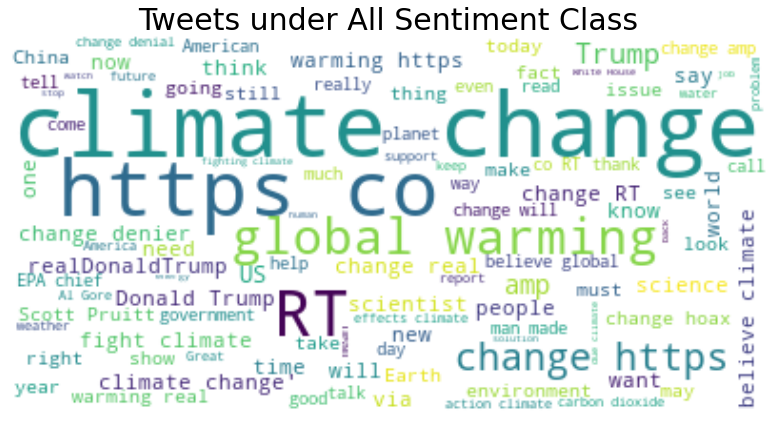

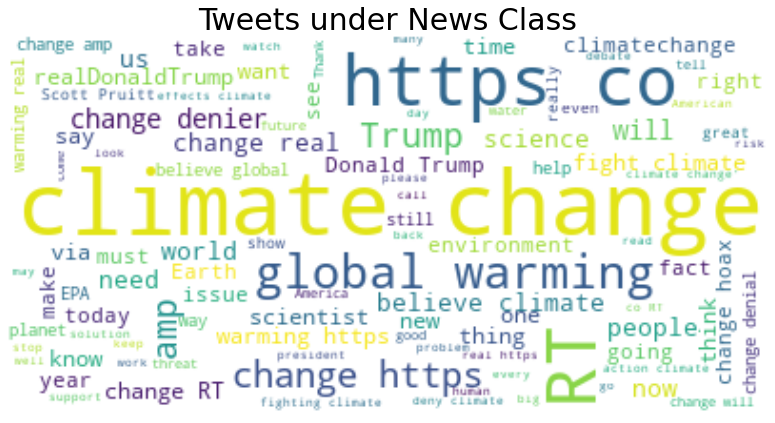

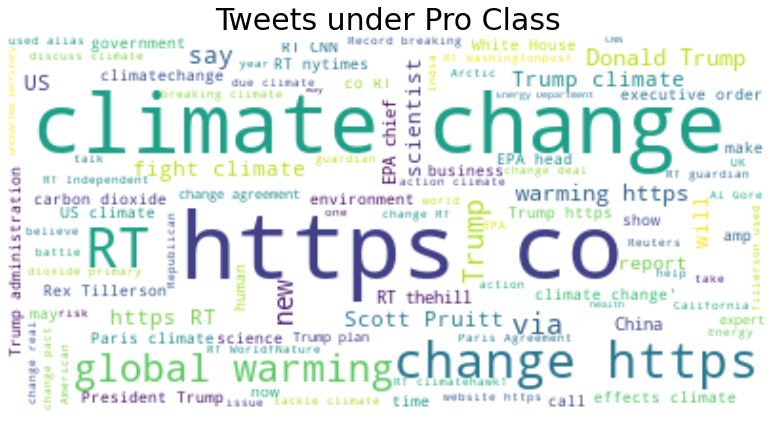

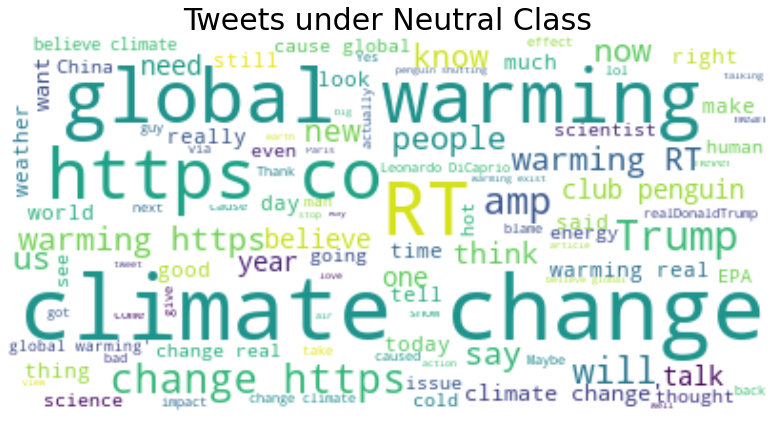

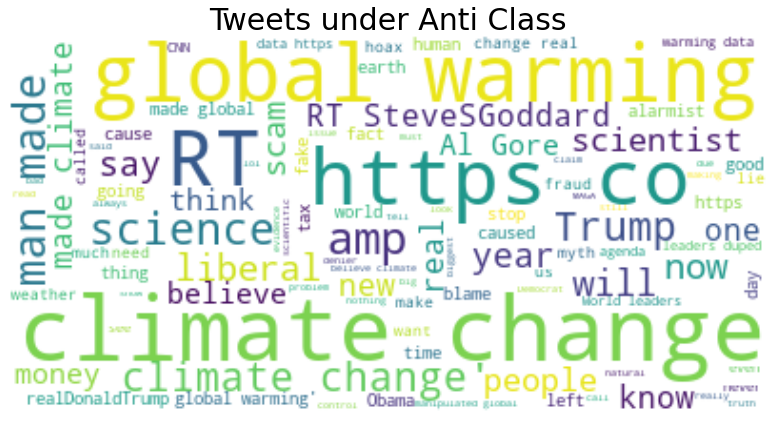

In [33]:
#fig, ax = plt.subplots(5, 1, figsize  = (35,40))
# Create and generate a word cloud image:
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(All_messages)
wordcloud_news = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(messages_1)
wordcloud_pro = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(messages_2)
wordcloud_neutral = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(messages_0)
wordcloud_anti = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(messages_minus_1)

wordcloud_dict = {wordcloud_all:'All Sentiment',
                  wordcloud_news:'News',
                  wordcloud_pro:'Pro',
                  wordcloud_neutral:'Neutral',
                  wordcloud_anti:'Anti'}

# Display the generated image:
for k, v in wordcloud_dict.items():
    
    fig, ax = plt.subplots(figsize = (15,7))
    plt.imshow(k, interpolation='bilinear')
    plt.title(f'Tweets under {v} Class', fontsize=30)
    plt.axis('off')
    
    plt.show()

Upon analysis of all the sentiment classes, "climate change", "RT", "https", "co" and "global warming" are the most popular words/phrases. Even within the individual sentiment classes, the same five words/phrases are the most common.

## 7.5. URL extraction

In [34]:
def http_extractor(df):

    df["web_pages"] = df.message.str.findall(r'https?://\S+')
    df["web_pages"] = [''.join(map(str, lists)).lower() for lists in df['web_pages']]
    pattern_url = r'https?://\S+'
    subs_url = r'url-web'
    df['post'] = df['web_pages'].replace(to_replace = pattern_url, value = subs_url, regex = True)

    return(df)

In [35]:
http_extractor(df).head()

,sentiment,message,tweetid,clean_tweet,word count,count_characters,punctuation_count,hashtags,web_pages,post
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,19,140,12,[],https://t.co/yelvcefxkc,url-web
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,10,62,1,[],,
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say three years act cl...,19,140,12,[],https://t.co/wdt0kdur2fhttps://t.co/z0anpt…,url-web
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,15,99,8,[todayinmaker#],https://t.co/44wotxtlcd,url-web
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas racist sexist climate chang...,18,122,8,[electionnight],,


In [36]:
df["postid"] = ['Yes' if url != '' else 'No' for url in df["post"]]
post_id = pd.DataFrame(df.groupby('sentiment')['postid'].value_counts())
post_id

postid
sentiment postid        
-1        No         709
          Yes        512
 0        No        1481
          Yes        763
 1        No        3879
          Yes       3343
 2        Yes       3125
          No         417

Most of the URLs are present in tweets pertaining to pro-man made climate change tweets (class 1) followed closely by News related tweets (class 2). Anti-climate change tweets (class -1) had the least URLs. It can be deducted that the pro climate change tweeters and the News twitters send out tweets that are accompanied by factual proofs to substantiate the contents of the tweets.


<a id="pp"></a>
# 8. Feature Engineering

Feature engineering is the process of selecting and transforming variables into an idealformat before using them in predictive model. The features in the data will directly influence the predictive models we use and the results we obtain. In this section we are going to select our feature variable, address the imbalance in the sentiment distribution and transform our features for model training.

## 8.1. Select feature and label variables

In [37]:
# Assign feature and response variables
X = df['clean_tweet']
y = df['sentiment']

## 8.2. Class imbalance

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally. This is evident in the dataset where sentiment class  is twice the size of the second largest sentiment class.

To rectify this problem,a resampling technique will be employed. The technique entails the following:

1. Add copies of instances from the under-represented class; this is called over-sampling (or more formally sampling with replacement), or
2. Delete instances from the over-represented class; this is called under-sampling.

In [38]:
heights = [len(y[y == label]) for label in [0, 1, 2, -1]]
bars = pd.DataFrame(zip(heights, [0,1,2,-1]), columns=['heights','labels'])
bars = bars.sort_values(by='heights',ascending=True)

In [39]:
# Let's pick a class size of roughly half the size of the largest size
class_size = 3500

bar_label_df = bars.set_index('labels')

resampled_classes = []

for label in [0, 1, 2, -1]:
    # Get number of observations from this class
    label_size = bar_label_df.loc[label]['heights']

    # If label_size < class size the upsample, else downsample
    if label_size < class_size:
        # Upsample
        label_data = df[['clean_tweet', 'sentiment']][df['sentiment'] == label]
        label_resampled = resample(label_data,
                                   # sample with replacement
                                   # (we need to duplicate observations)
                                   replace=True,
                                   # number of desired samples
                                   n_samples=class_size,
                                   random_state=27)
    else:
        # Downsample
        label_data = df[['clean_tweet', 'sentiment']][df['sentiment'] == label]
        label_resampled = resample(label_data,
                                   # sample without replacement
                                   # (no need for duplicate observations)
                                   replace=False,
                                   # number of desired samples
                                   n_samples=class_size,
                                   random_state=27)

    resampled_classes.append(label_resampled)

In [40]:
# Assign feature and response variables from resampled data
resampled_data = np.concatenate(resampled_classes, axis=0)

X_resampled = resampled_data[:, :-1]
y_resampled = resampled_data[:, -1]

In [41]:
# Plot original original data with resampled data
heights = [len(y_resampled[y_resampled == label]) for label in [0, 1, 2, -1]]
bars_resampled = pd.DataFrame(zip(heights, [0, 1, 2, -1]),
                              columns=['heights', 'labels'])
bars_resampled = bars_resampled.sort_values(by='heights', ascending=True)

fig = go.Figure(data=[
    go.Bar(name='Original', x=[-1, 0, 2, 1], y=bars['heights']),
    go.Bar(name='Resampled', x=[-1, 0, 2, 1], y=bars_resampled['heights'])
])
fig.update_layout(xaxis_title="Sentiment", yaxis_title="Sample size")
fig.show()

After addressing the imbalance in the data, all the sentiment classes feature 3 500 observations. This will give each class equal weighting when the classifiers are trained.

In [42]:
df_resampled = pd.DataFrame(X_resampled.reshape(-1,1))
df_resampled.columns = ['tweet']
df_resampled['sentiment'] = y_resampled
df_resampled['sentiment'] = df_resampled['sentiment'].astype('int')

In [43]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
                                   df_resampled['tweet'].values,
                                   df_resampled['sentiment'].values,
                                   test_size=0.1, random_state=42)

In [44]:
# Check shape of the split data
print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (12600,)
Testing Data Shape:  (1400,)


## 8.3. Tokenization and lemmatization


* Tokenization is the process of splitting a string/text into a list of tokens. One can think of token as a small part, like a word is a token in a sentence and a sentence is a token in a paragraph.

* Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. It is similar to stemming but it brings context to the words. 

In [45]:
# Create a spaCy tokenizer
spacy.load('en')
lemmatizer = spacy.lang.en.English()


def tokenize(text):
    """
    Takes in text, tokenizes words, then lemmatizes tokens.

    Parameters:
    ---------
    text (str):String text

    Returns:
    ---------
    list of str:Lammitzed tokens

    """
    tokens = lemmatizer(text)
    return [token.lemma_ for token in tokens]

## 8.4. Vectorization

In order to analyse preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques such as Bag-of-Words, Term Frequency–Inverse Document Frequency (TF-IDF) and Word Embedding. For this project, only Bag-of-Words and TF-IDF will be used. These are types of evctorisers. Vectorisers take text and converts it into a matrix of vectors.

### Count vectorizer

The Bag-of-Words method describes the occurrence of words within a document. To effectively demonstrate this technique, let us take a corpus (a collection of texts) called C of D documents {d1,d2,....,dD} and N unique tokens have been extracted out of the corpus C. The N tokens (words) will form a list and the size of the bag-of-words matrix (M) will be given by D x N.

Each row in the matrix M contains the frequency of tokens in document D(i).


${Example:}$

D1: He is a smart boy. She is also smart.

D2: He likes smart people.

<table>
  <thead>
    <tr>
      <th></th>
      <th>He</th>
      <th>She</th>
      <th>He</th>
      <th>likes</th>
      <th>smart</th>
      <th>boy</th>
      <th>people</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>D1</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>2</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>D2</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
    </tr>
  </tbody>
</table>

### TF-IDF vectorizer

This is another method which is based on the frequency but it is different to the Bag-Of-Words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet), but in the entire corpus.

TF-IDF penalises the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear a significant numbe rof times in the document.

Important terms related to TF-IDF are:


$\alpha$ = Number of times term t appears in a document

$\beta$ = Number of terms in the document

$$TF = \frac{\alpha}{\beta}$$

$$IDF = log{(\frac{N}{n})}$$ 

where, **N** is the number of documents and **n** is the number of documents a **term t** has appeared in.

$$TF-IDF = TF*IDF$$

In [46]:
# Define multiple vectorizers to test which one gives us the best accuracy
vectorizer_dict = {'CV_1': CountVectorizer(max_df=0.8, min_df=3,
                                           tokenizer=tokenize,
                                           stop_words=stop_words),
                   'CV_2': CountVectorizer(ngram_range=(1, 3), max_df=0.8,
                                           min_df=3, tokenizer=tokenize,
                                           stop_words=stop_words),
                   'CV_3': CountVectorizer(ngram_range=(2, 3), max_df=0.8,
                                           min_df=3, tokenizer=tokenize,
                                           stop_words=stop_words),
                   'TF_1': TfidfVectorizer(max_df=0.8, min_df=3,
                                           tokenizer=tokenize,
                                           stop_words=stop_words),
                   'TF_2': TfidfVectorizer(ngram_range=(1, 3), max_df=0.8,
                                           min_df=3, tokenizer=tokenize,
                                           stop_words=stop_words),
                   'TF_3': TfidfVectorizer(ngram_range=(2, 3), max_df=0.8,
                                           min_df=3, tokenizer=tokenize,
                                           stop_words=stop_words)}

<a id="mod"></a>
# 9. Modelling

In this section, machine learning algorithms that will predict the labels from the features presented will be trained. Several models (logistic rgeression, Naive Bayes, linear support vector machine, neural network, decision tree and XGBoost) will be trained in order to test their performance and see which one does the best job classifying our unseen data. Below is a basic breakdown of each model.

1. **Logistic Regression** - Logistic regression is one of the most widely used algorithms for classifying catgorical data. This method predicts the probability of an observation belonging to a class using a logit function. A probability threshold is determined and is used to allocate an observation to a label. 0.5 is typically chosen as the threshold. The logit function is defined as follows:

$$P(X) = \displaystyle \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}}$$

where $P(X)$ is the probability of X belonging to class 1, and $\beta_0$ and $\beta_1$ are the intercept and regression coefficient respectively. $P(X)$ > 0.1 is assigned class 1 and $P(X)$ < 0 is assigned class 0. With multiclasses, a "One vs Rest" approach can be used where a logistic regression model is trained for each label or cross-entropy loss.

2. **Naive Bayes** - This method uses the principle of Bayes Theorem (conditional probability) to classify observations into classes. The algorithm assumes that there is independence between variables (X and Y). This is displayed in the equation

$$
P(X \cap Y) = P(X)P(Y)
$$

Even besides this assumption, it works well with multiclass classification. The algorithm calculates the probability of each labels for a given text and then outputs the label with the highest one.

3. **Linear Support Vector Machine** - Support vector machines are based on the idea of hyperplanes seperating classes in a  linear manner. Support vectors are data points found close to the hyperplane and are considered critical points in the dataset as they impact the position of the hyperplane. The further away that points are from hyperplanes, the better.

4. **Neural Network** - A neural network is essentially a network of functions feeding into each other and are designed to recognise patterns.

5. **Decision Tree** - A decision tree algorithms make decisions by selecting an attribute and makes it a decision node. At the decision node, smaller subsets off the data is created by splitting the data according to the outcome of a condition set. This process is repeatedly recursively until the maximum depth of the trees is reached. In classifitcaton, the split points can be made using the Information Gain, Gain Ratio and Gini Index methods.

6. **XGBoost** - XGBoost (eXtreme Gradient Boosting) is a type of ensemble model (a method that trains and predicts many models at once to produce a single superior output). It is based on the concept of boosting weak learners to strong learners.

In [47]:
# Define multiple models to test which one gives us the best accuracy
model_dict = {'Logistic Regression': LogisticRegression(max_iter=1000),
              'Naive Bayes': MultinomialNB(),
              'LinearSVM': SGDClassifier(random_state=42),
              'Non-linear SVM': SVC(gamma="scale"),
              'Neural Network': MLPClassifier(),
              'Decision Tree': DecisionTreeClassifier(max_depth=6),
              'XGBoost': XGBClassifier(max_depth=6)
              }

A classification report is a representation of the main classification metrics on a per-class/sentiment basis. Its used to describe the performance of a classifier. This gives a deeper intuition of the classifier behavior over global accuracy.

The metrics are defined in terms of true and false positives, and true and false negatives. Positive and negative in this case are generic names for the classes of a binary classification problem. A true positive is when the actual class is positive as is the estimated class. A false positive is when the actual class is negative but the estimated class is positive. This is also referred to as a Type 1 error. A true negative is when the actual class is negative as is the estimated class. A false negative is when the actual class is negative but the estimated class is positive. This is also referred to as a Type 2 error. Using this terminology the metrics are defined as follows:

* Precision - This is the ability of a classiifer not to label an instance positive that is actually negative.


$$ Precision = \frac{TP}{TP \space + FP} = \frac{TP}{Total \space Predicted \space Positive} $$

* Recall - This is the ability of a classifier to find all positive instances. 

$$ Recall = \frac{TP}{TP \space + FN} = \frac{TP}{Total \space Actual \space Positive}$$


* F1 score - The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 


$$F_1 = 2 \times \frac {Precision \space \times \space Recall }{Precision \space + \space Recall }$$

In [ ]:
# Run each classifier for each vectorizer
classifier_results_dict = defaultdict(list)
for vec_name, vectorizer in vectorizer_dict.items():

    X_train_v = vectorizer.fit_transform(X_train)
    X_test_v = vectorizer.transform(X_test)
    print(vec_name)  # keep track of progress

    for mod_name, model in model_dict.items():
        model.fit(X_train_v, y_train)
        y_pred_v = model.predict(X_test_v)

        precision_v = round(100*precision_score(y_test, y_pred_v,
                            average='weighted'), 3)
        recall_v = round(100*recall_score(y_test, y_pred_v,
                         average='weighted'), 3)
        f1_v = round(2*(precision_v*recall_v) / (precision_v+recall_v), 3)

        classifier_results_dict['Vectorizer Type'].append(vec_name)
        classifier_results_dict['Model Name'].append(mod_name)
        classifier_results_dict[('Precision')].append(precision_v)
        classifier_results_dict[('Recall')].append(recall_v)
        classifier_results_dict[('F1-score')].append(f1_v)

classifier_results_df = pd.DataFrame(classifier_results_dict)

In [ ]:
# Checking result
classifier_results_df.sort_values(by='F1-score',
                                  ascending=False).reset_index(drop=True)

Majority of the combinations between the different classifiers and vectorisers performed well classifying above 70% of the dataset correctly. The model that came out on top though is the non-linear SVM with a F1-score of 83.50

<a id="me"></a>
# 10. Model evaluation

In [ ]:
fig = px.bar(classifier_results_df, x="Model Name", y="F1-score", color='Vectorizer Type',
             barmode='group', height=400)
fig.show()

In [ ]:
# Best Model

# Best Model: TF_1    Non-linear SVM
model_svc = SVC(gamma="scale")

# Vectorization
vectorizer = vectorizer_dict['TF_1']
X_train_TF_1 = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

In [ ]:
#log metrics on Comet,where 'metrics' is a dictionary of metrics
metrics = classifier_results_df.to_dict('index')
experiment.log_metrics(metrics)

In [ ]:
model_svc.fit(X_train_TF_1, y_train)
y_pred_cv = model_svc.predict(X_test_cv)

precision_cv = round(100*precision_score(y_test, y_pred_cv,
                     average='weighted'), 3)
recall_cv = round(100*recall_score(y_test, y_pred_cv, average='weighted'), 3)
f1_cv = round(2*(precision_cv * recall_cv) / (precision_cv + recall_cv), 3)

In [ ]:
print(classification_report(y_test, y_pred_cv))

In [ ]:
# Print metrics scores
print('Precision Score:', precision_cv)
print('Recall Score:', recall_cv)
print('f1_Score:', f1_cv)

In [ ]:
# Confusion Matrix
confusion_matrix(y_test, y_pred_cv)

The confusion matrix lives up to it's name! This is a matrix that shows the correct predictions vs. the true values that it predicted against. It can be visualised to make it a bit more understandable and appealing.

In [ ]:
# Enhance confusion matrix using a heatmap
cm =confusion_matrix(y_test, y_pred_cv)

categories = ['Anti','Neutral','Pro','News']
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(cm, ax = ax, annot=True, fmt='g', xticklabels=categories, yticklabels=categories, cbar=False,
            cmap='Greens')
plt.suptitle('Confusion Matrix of Support Vector Classifier used with a TF-IDF Vectorizer')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.show()

The easiest way to understand how a confusion matrix works is that it shows the number of times it correctly predicted a class vs the number of times it incorrectly identified a class. The main thing to look for is the diagonal line starting at the top left to bottom right, this shows how many times the model predicted correctly. The higher the values in these areas and lower values in all other areas the better.

In [ ]:
#Creating csv for submission

# Vectorizing and Normalizing the test data
test_data = vectorizer.transform(test['clean_tweet'])
test_data_norm = preprocessing.normalize(test_data)

# Making a submission dataframe
df_submission = pd.DataFrame()
df_submission['tweetid'] = test['tweetid']

y_test_data = model_svc.predict(test_data_norm) 
df_submission['sentiment'] = y_test_data

# Creating a csv file
df_submission.to_csv('Submission_file_SVC.csv', index=False)

<a id="conc"></a>
# 11. Conclusion

After pre-processing, a tweet is compared between the correct predictions versus the true ones. This aids the machine in differentiating between true and predicted sentiment values enabling the machine to seek out key words,characters,phrases that play a role in the sentiment value. Using Natural Language Processes we performed the following to assist our model in determining sentiment values:
1) Searched for null values and duplicates;
2) Removed empty strings,special characters and stop words;

Once this process was complete, the biggest factor hindering optimum results was the class imbalance. Majority of the tweets Pro climate change made up 50.76% of the data and to avoid the model being biased towards classifying sentiments as the majority class, this had to be addressed either through Upsampling or Down-sampling or both. WUpon further analysis, it was picked up that majority of the news sentimen tweets contain hyperlinks and these could be seen as the determining factors of assigning the news sentiment to the relevant tweet. This could not be used as a distinguishng feature as it was not really significant. The classification report shows a representation of the main classification metrics on a per-class/sentiment basis. Using feature engineering, the data was processed to a point where the best algorithm (non-linear SVC) could predict effectively without bias.

With the following scores:
**Precision Score: 83.507
**Recall Score: 83.5
**f1_Score: 83.503

The designed algorithm has a high ability to determine which tweets fall under the relative sentiment and aids to make well informed decisions in determining whether or not a person believes in climate change, based on their novel tweet data.

<a id="ecomet"></a>
# 12. End Comet experiment

In [ ]:
experiment.end()

In [ ]:
experiment.display()